<a href="https://colab.research.google.com/github/anshulk-cmu/RA-LLM-Interpretability-Task/blob/main/RA_LLM_Interpretability_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive and load dataset
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configure visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Mount drive and load data
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/RA_Application_Task.csv')

Mounted at /content/drive


In [2]:
df.head()

,Comparable zpid,Comparable Sale Price,Bedrooms,Bathrooms Comparable,LotSize Comparable,YearBuilt Comparable
0,11429293,216000,3,2,9387,1957
1,11468456,205000,3,2,6000,1957
2,11469598,207000,3,2,6695,1958
3,11546644,215000,3,3,8450,1958
4,11546655,230000,3,2,8925,1960


### 1. Data Validation & Quality Assessment

In [3]:
# Initial Inspection: Shape, Dtypes, Missing Values
print(f"Dataset Shape: {df.shape}")
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (38, 6)

Data Types:
Comparable zpid          int64
Comparable Sale Price    int64
Bedrooms                 int64
Bathrooms Comparable     int64
LotSize Comparable       int64
YearBuilt Comparable     int64
dtype: object

Missing Values:
Comparable zpid          0
Comparable Sale Price    0
Bedrooms                 0
Bathrooms Comparable     0
LotSize Comparable       0
YearBuilt Comparable     0
dtype: int64


In [4]:
# Verify zpid uniqueness
duplicate_mask = df.duplicated('Comparable zpid', keep=False)
duplicates = df[duplicate_mask]
num_duplicates = df.duplicated('Comparable zpid').sum()

print(f"Number of duplicate zpids: {num_duplicates}")
if num_duplicates > 0:
    print("\nDuplicate Entries (Preview):")
    display(duplicates.sort_values('Comparable zpid').head())

Number of duplicate zpids: 2

Duplicate Entries (Preview):


,Comparable zpid,Comparable Sale Price,Bedrooms,Bathrooms Comparable,LotSize Comparable,YearBuilt Comparable
1,11468456,205000,3,2,6000,1957
30,11468456,205000,3,2,6000,1957
2,11469598,207000,3,2,6695,1958
32,11469598,207000,3,2,6695,1958


In [5]:
# Statistical summary
display(df.describe())

,Comparable zpid,Comparable Sale Price,Bedrooms,Bathrooms Comparable,LotSize Comparable,YearBuilt Comparable
count,3.800000e+01,38.00000,38.0,38.000000,38.000000,38.000000
mean,1.148069e+07,203581.00000,3.0,1.868421,6786.657895,1951.973684
std,9.091646e+04,36811.04269,0.0,0.414015,1657.007695,10.106158
min,1.131393e+07,128000.00000,3.0,1.000000,3001.000000,1925.000000
25%,1.142036e+07,176250.00000,3.0,2.000000,6009.250000,1949.250000
50%,1.146892e+07,205500.00000,3.0,2.000000,6695.000000,1955.000000
75%,1.154665e+07,219000.00000,3.0,2.000000,7951.000000,1958.000000
max,1.165682e+07,283000.00000,3.0,3.000000,9387.000000,1965.000000


In [6]:
# Validate Value Ranges & Quality Issues
print("Quality Checks:")

# Prices positive
invalid_prices = df[df['Comparable Sale Price'] <= 0]
print(f"- Non-positive prices: {len(invalid_prices)}")

# Logical Bedrooms/Bathrooms
invalid_beds = df[df['Bedrooms'] < 0]
invalid_baths = df[df['Bathrooms Comparable'] < 0]
print(f"- Negative bedrooms: {len(invalid_beds)}")
print(f"- Negative bathrooms: {len(invalid_baths)}")

# Years valid (Checking against mentioned range 1925-1965)
year_col = 'YearBuilt Comparable'
out_of_range_years = df[(df[year_col] < 1925) | (df[year_col] > 1965)]
print(f"- Years outside 1925-1965: {len(out_of_range_years)}")
print(f"  (Min Year: {df[year_col].min()}, Max Year: {df[year_col].max()})")

# Zero lot sizes
zero_lot = df[df['LotSize Comparable'] <= 0]
print(f"- Zero/Negative Lot Sizes: {len(zero_lot)}")

Quality Checks:
- Non-positive prices: 0
- Negative bedrooms: 0
- Negative bathrooms: 0
- Years outside 1925-1965: 0
  (Min Year: 1925, Max Year: 1965)
- Zero/Negative Lot Sizes: 0


### 2. Exploratory Data Analysis (EDA)

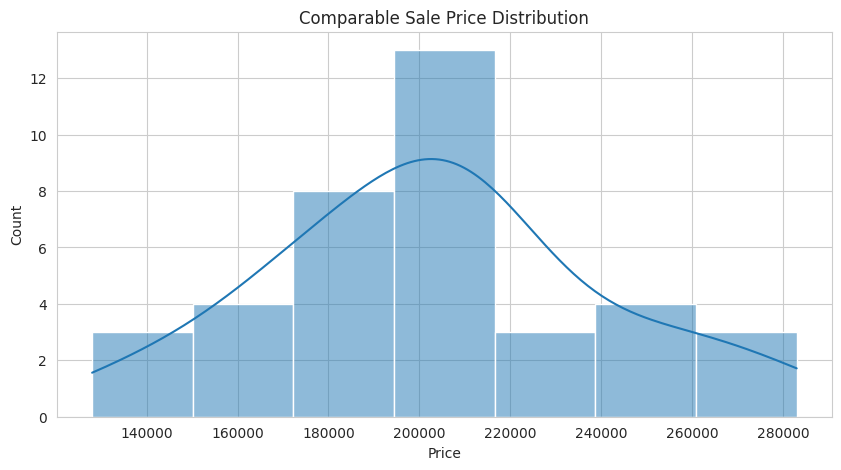

Shapiro-Wilk Test for Normality (Price):
Statistic=0.9793, p-value=0.6933
Distribution looks Normal (fail to reject H0)


In [7]:
# Univariate Analysis: Price Distribution & Normality
plt.figure(figsize=(10, 5))
sns.histplot(df['Comparable Sale Price'], kde=True)
plt.title('Comparable Sale Price Distribution')
plt.xlabel('Price')
plt.show()

# Shapiro-Wilk Test for Normality
shapiro_test = stats.shapiro(df['Comparable Sale Price'])
print(f"Shapiro-Wilk Test for Normality (Price):\nStatistic={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")
if shapiro_test.pvalue > 0.05:
    print("Distribution looks Normal (fail to reject H0)")
else:
    print("Distribution does NOT look Normal (reject H0)")

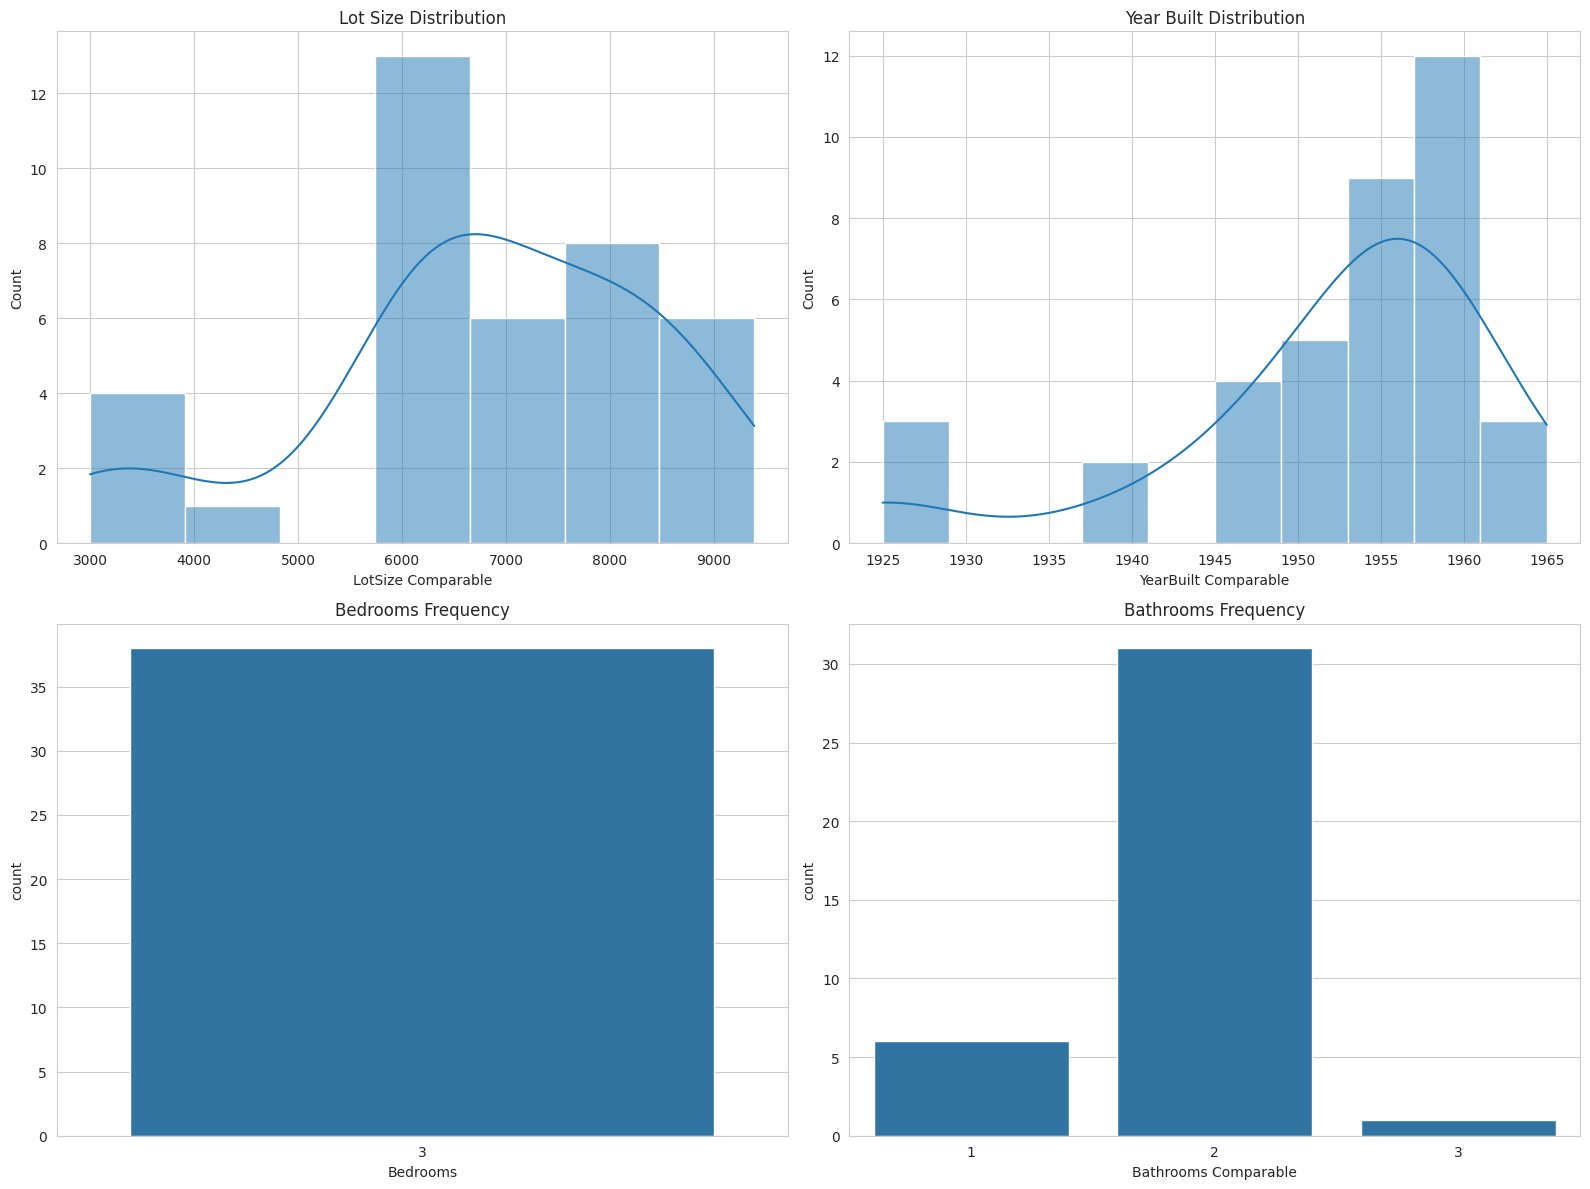

In [8]:
# Univariate Analysis: Other Features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Lot Size Distribution
sns.histplot(df['LotSize Comparable'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Lot Size Distribution')

# Year Built Distribution
sns.histplot(df['YearBuilt Comparable'], bins=10, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Year Built Distribution')

# Bedrooms Frequency
sns.countplot(x='Bedrooms', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Bedrooms Frequency')

# Bathrooms Frequency
sns.countplot(x='Bathrooms Comparable', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Bathrooms Frequency')

plt.tight_layout()
plt.show()

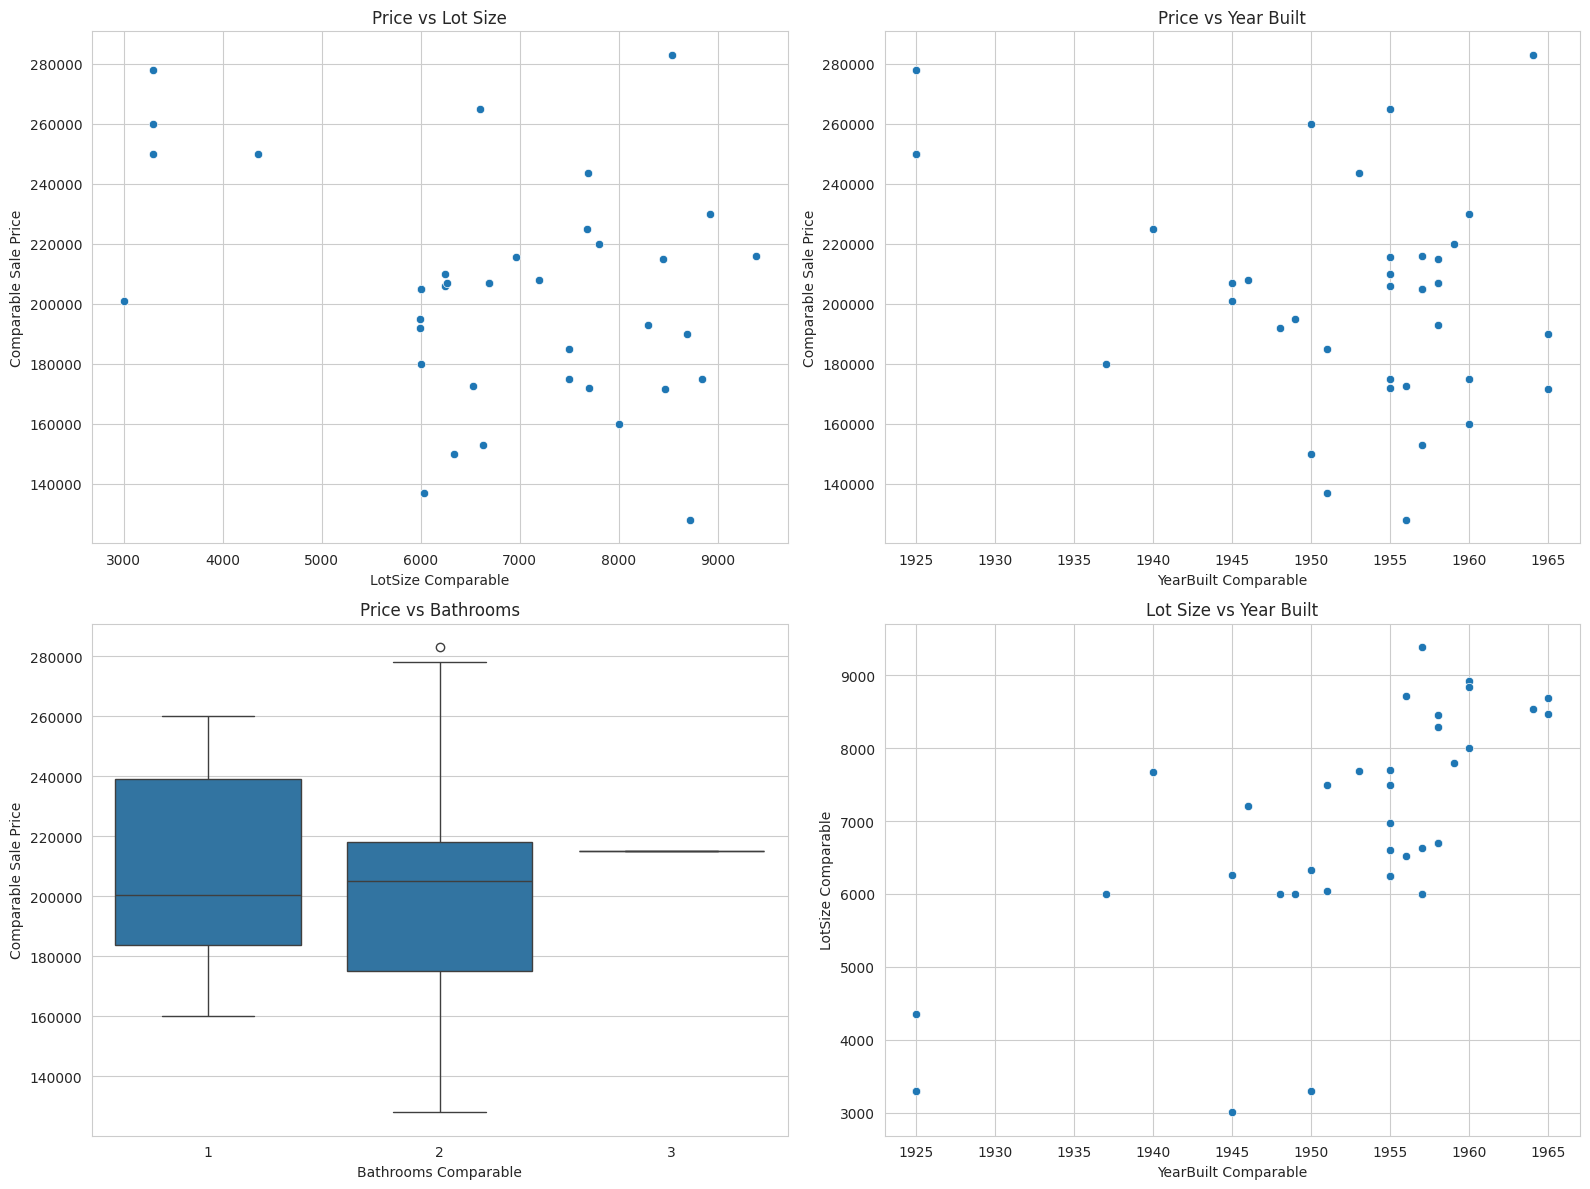

In [9]:
# Bivariate Relationships
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Price vs Lot Size
sns.scatterplot(x='LotSize Comparable', y='Comparable Sale Price', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Price vs Lot Size')

# 2. Price vs Year Built
sns.scatterplot(x='YearBuilt Comparable', y='Comparable Sale Price', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Price vs Year Built')

# 3. Price vs Bathrooms
sns.boxplot(x='Bathrooms Comparable', y='Comparable Sale Price', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Price vs Bathrooms')

# 4. Lot Size vs Year Built
sns.scatterplot(x='YearBuilt Comparable', y='LotSize Comparable', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Lot Size vs Year Built')

plt.tight_layout()
plt.show()

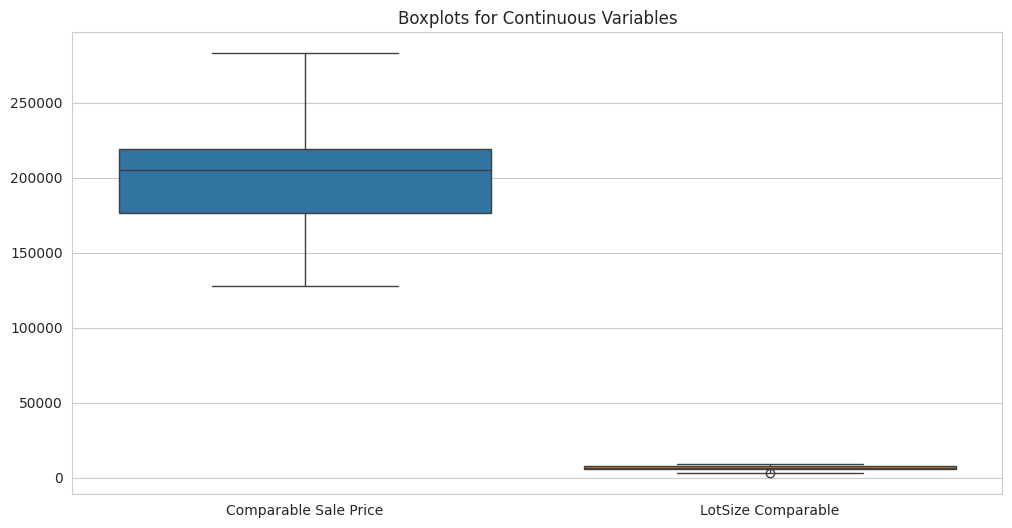

Outlier Analysis:
Feature 'Comparable Sale Price':
  - Z-score outliers (|z| > 3): 0
  - IQR outliers: 0
Feature 'LotSize Comparable':
  - Z-score outliers (|z| > 3): 0
  - IQR outliers: 1


In [10]:
# Outlier Detection
continuous_cols = ['Comparable Sale Price', 'LotSize Comparable']

# Visual Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[continuous_cols])
plt.title('Boxplots for Continuous Variables')
plt.show()

# Statistical Detection (Z-score & IQR)
print("Outlier Analysis:")
for col in continuous_cols:
    # Z-score method
    z_scores = np.abs(stats.zscore(df[col]))
    z_outliers = np.sum(z_scores > 3)

    # IQR method
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    iqr_outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()

    print(f"Feature '{col}':")
    print(f"  - Z-score outliers (|z| > 3): {z_outliers}")
    print(f"  - IQR outliers: {iqr_outliers}")

### 3. Feature Engineering

In [11]:
# 1. Duplicate Resolution
print(f"Shape before deduplication: {df.shape}")

# Drop duplicates based on zpid, keeping the first occurrence
df_clean = df.drop_duplicates(subset='Comparable zpid', keep='first').copy()

print(f"Shape after deduplication: {df_clean.shape}")

Shape before deduplication: (38, 6)
Shape after deduplication: (36, 6)


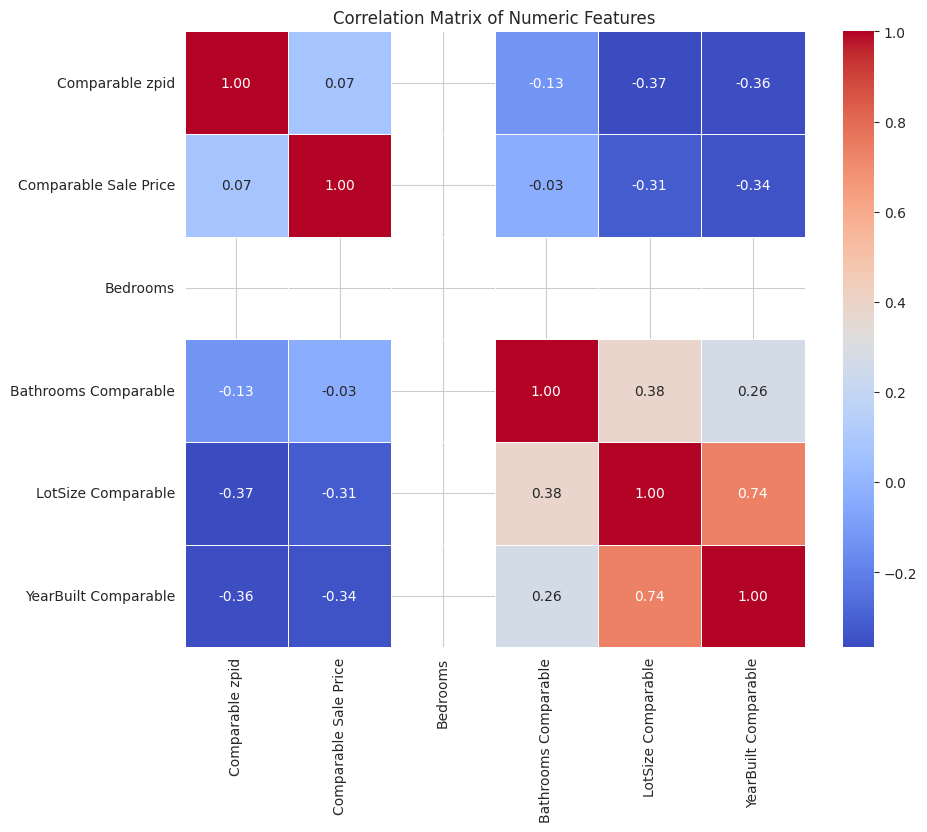


Correlations with Price:
Comparable Sale Price    1.000000
Comparable zpid          0.071278
Bathrooms Comparable    -0.033026
LotSize Comparable      -0.314661
YearBuilt Comparable    -0.341958
Bedrooms                      NaN
Name: Comparable Sale Price, dtype: float64


In [12]:
# 2. Correlation Analysis
plt.figure(figsize=(10, 8))

# Select numeric columns only
numeric_df = df_clean.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Plot Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Identify strongest correlation with price
price_corr = corr_matrix['Comparable Sale Price'].sort_values(ascending=False)
print("\nCorrelations with Price:")
print(price_corr)

In [13]:
# 3. Feature Engineering

# Home Age (assuming current year 2024)
df_clean['home_age'] = 2024 - df_clean['YearBuilt Comparable']

# Price per SqFt Lot
df_clean['price_per_sqft_lot'] = df_clean['Comparable Sale Price'] / df_clean['LotSize Comparable']

# Lot Size Normalization
# Z-score
df_clean['lotsize_zscore'] = stats.zscore(df_clean['LotSize Comparable'])
# Min-Max
df_clean['lotsize_minmax'] = (df_clean['LotSize Comparable'] - df_clean['LotSize Comparable'].min()) / (df_clean['LotSize Comparable'].max() - df_clean['LotSize Comparable'].min())

# Construction Era
def categorize_era(year):
    if year < 1945:
        return 'Pre-War'
    elif 1945 <= year <= 1955:
        return 'Post-War'
    else:
        return 'Mid-Century'

df_clean['construction_era'] = df_clean['YearBuilt Comparable'].apply(categorize_era)

# Has Extra Bath (Binary indicator)
df_clean['has_extra_bath'] = (df_clean['Bathrooms Comparable'] >= 2).astype(int)

# Age Category (Binning)
# Using quartiles to define 'Historic', 'Vintage', 'Mid-Age', 'Modern' based on distribution
df_clean['age_category'] = pd.qcut(df_clean['YearBuilt Comparable'], q=4, labels=['Historic', 'Vintage', 'Mid-Age', 'Modern'])

print("New Features Created:")
display(df_clean[['home_age', 'price_per_sqft_lot', 'construction_era', 'has_extra_bath', 'age_category']].head())

New Features Created:


,home_age,price_per_sqft_lot,construction_era,has_extra_bath,age_category
0,67,23.010547,Mid-Century,1,Mid-Age
1,67,34.166667,Mid-Century,1,Mid-Age
2,66,30.918596,Mid-Century,1,Mid-Age
3,66,25.443787,Mid-Century,1,Mid-Age
4,64,25.770308,Mid-Century,1,Modern


In [14]:
# 4. Stratified Subset Creation

# Price Quartiles
df_clean['price_quartile'] = pd.qcut(df_clean['Comparable Sale Price'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

print("Price Quartile Distribution:")
print(df_clean['price_quartile'].value_counts())

# Similar Homes Clusters (Group by Bathrooms and Age Category)
clusters = df_clean.groupby(['Bathrooms Comparable', 'age_category'], observed=False).size()
print("\nSample Clusters (Bathrooms, Age Category):")
print(clusters[clusters > 0])

# Edge Cases (Outliers based on Price or Lot Size Z-score > 2.5 for demonstration)
edge_cases = df_clean[
    (np.abs(stats.zscore(df_clean['Comparable Sale Price'])) > 2.5) |
    (np.abs(stats.zscore(df_clean['LotSize Comparable'])) > 2.5)
]
print(f"\nIdentified {len(edge_cases)} potential edge cases for stress testing.")

Price Quartile Distribution:
price_quartile
Low         10
Mid-High     9
High         9
Mid-Low      8
Name: count, dtype: int64

Sample Clusters (Bathrooms, Age Category):
Bathrooms Comparable  age_category
1                     Historic        2
                      Vintage         3
                      Modern          1
2                     Historic        7
                      Vintage         9
                      Mid-Age         7
                      Modern          6
3                     Mid-Age         1
dtype: int64

Identified 0 potential edge cases for stress testing.


In [15]:
import json

# 5. Statistical Summary Report

# Collect statistics
stats_dict = {
    "dataset_metadata": {
        "original_shape": df.shape,
        "cleaned_shape": df_clean.shape,
        "duplicates_removed": df.shape[0] - df_clean.shape[0]
    },
    "feature_statistics": {
        "skewness": df_clean.select_dtypes(include=[np.number]).skew().to_dict(),
        "kurtosis": df_clean.select_dtypes(include=[np.number]).kurtosis().to_dict()
    },
    "correlation_with_price": df_clean.select_dtypes(include=[np.number]).corr()['Comparable Sale Price'].to_dict(),
    "outlier_analysis": {
        "edge_cases_identified": len(edge_cases)
    },
    "transformations_log": [
        "Deduplication (kept first)",
        "Feature Engineering: home_age, price_per_sqft_lot, lotsize_zscore, construction_era",
        "Categorization: age_category, price_quartile"
    ]
}

# Helper to handle numpy types for JSON
def convert_numpy(obj):
    if isinstance(obj, np.integer): return int(obj)
    if isinstance(obj, np.floating): return float(obj)
    if isinstance(obj, np.ndarray): return obj.tolist()
    return obj

# Save to JSON
with open('preprocessing_report.json', 'w') as f:
    json.dump(stats_dict, f, default=convert_numpy, indent=4)

print("preprocessing_report.json generated successfully.")
print("\nJSON Report Content:")
print(json.dumps(stats_dict, default=convert_numpy, indent=4))

preprocessing_report.json generated successfully.

JSON Report Content:
{
    "dataset_metadata": {
        "original_shape": [
            38,
            6
        ],
        "cleaned_shape": [
            36,
            14
        ],
        "duplicates_removed": 2
    },
    "feature_statistics": {
        "skewness": {
            "Comparable zpid": 0.3160914099725141,
            "Comparable Sale Price": 0.2155444700848478,
            "Bedrooms": 0.0,
            "Bathrooms Comparable": -0.9005121683896715,
            "LotSize Comparable": -0.8141700355295789,
            "YearBuilt Comparable": -1.4427952276412175,
            "home_age": 1.4427952276411955,
            "price_per_sqft_lot": 1.9487053317864347,
            "lotsize_zscore": -0.8141700355295789,
            "lotsize_minmax": -0.8141700355295797,
            "has_extra_bath": -1.867589160751476
        },
        "kurtosis": {
            "Comparable zpid": -0.42640759705123754,
            "Comparable Sale Pri

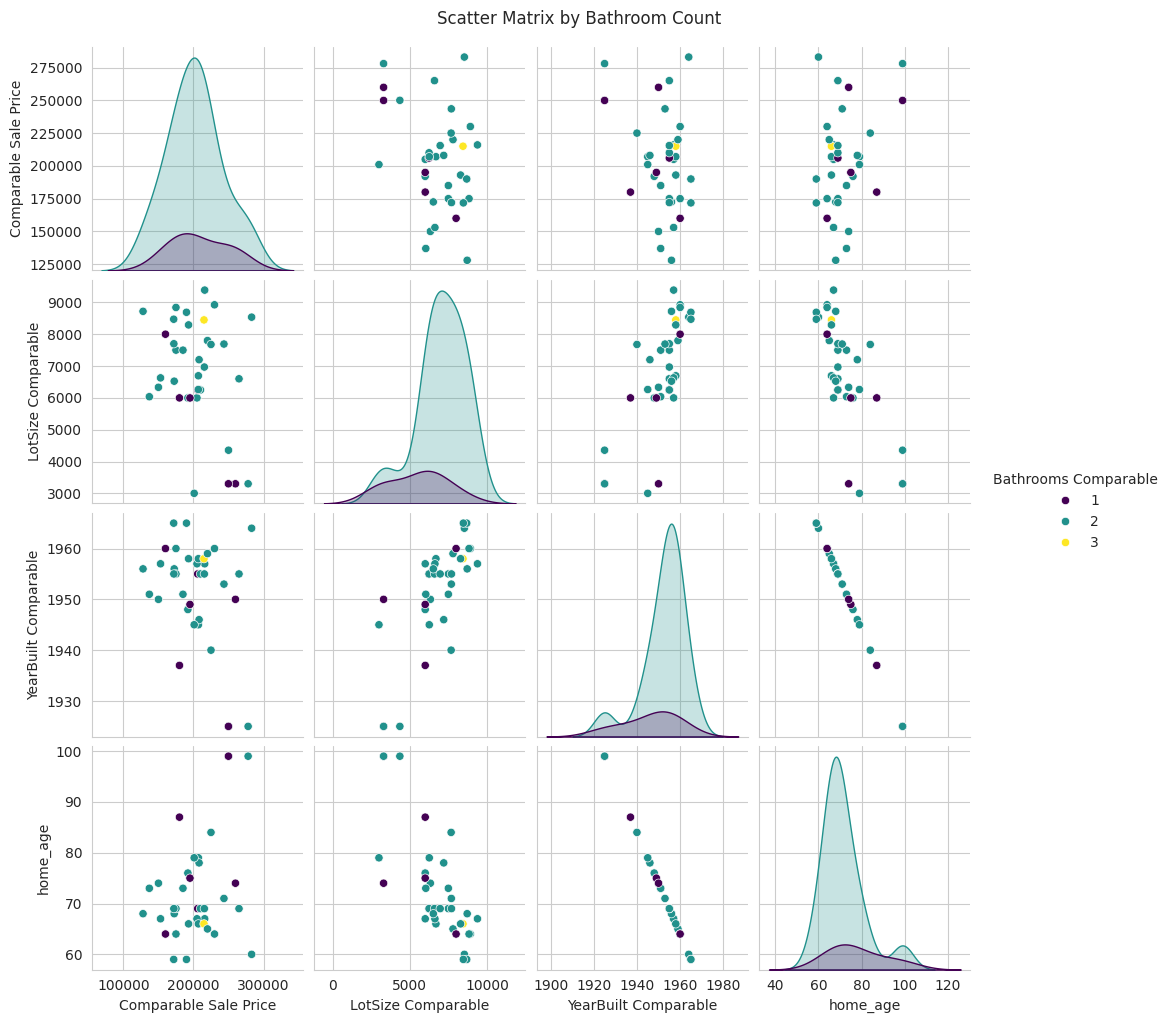

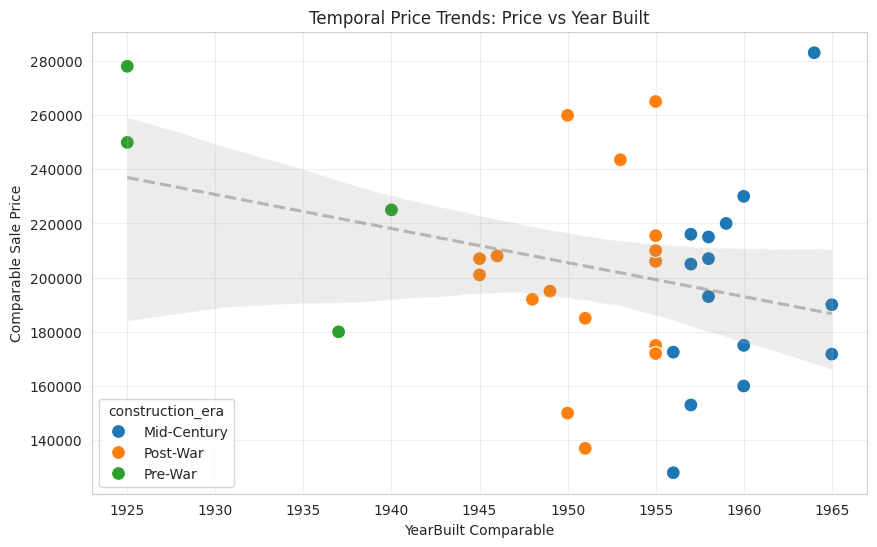

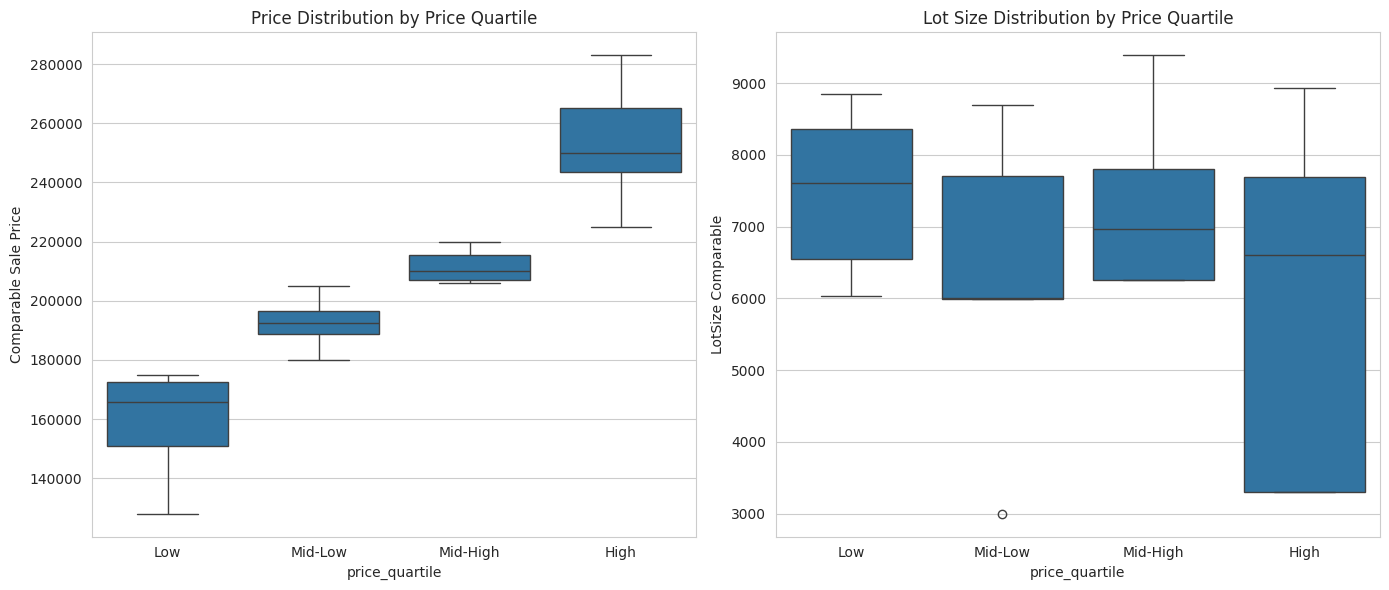

In [16]:
# 6. Final Visualizations

# Scatter Matrix colored by Bathroom count
sns.pairplot(df_clean,
             vars=['Comparable Sale Price', 'LotSize Comparable', 'YearBuilt Comparable', 'home_age'],
             hue='Bathrooms Comparable',
             palette='viridis')
plt.suptitle("Scatter Matrix by Bathroom Count", y=1.02)
plt.show()

# Temporal Price Trends
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='YearBuilt Comparable', y='Comparable Sale Price', hue='construction_era', s=100)
sns.regplot(data=df_clean, x='YearBuilt Comparable', y='Comparable Sale Price', scatter=False, color='gray', line_kws={'linestyle': '--', 'alpha': 0.5})
plt.title("Temporal Price Trends: Price vs Year Built")
plt.grid(True, alpha=0.3)
plt.show()

# Stratification Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Price distribution by Quartile
sns.boxplot(data=df_clean, x='price_quartile', y='Comparable Sale Price', ax=axes[0])
axes[0].set_title("Price Distribution by Price Quartile")

# Feature distribution across quartiles (e.g., Lot Size)
sns.boxplot(data=df_clean, x='price_quartile', y='LotSize Comparable', ax=axes[1])
axes[1].set_title("Lot Size Distribution by Price Quartile")

plt.tight_layout()
plt.show()

In [17]:
# 7. Data Export

# Full Processed Dataset
df_clean.to_csv('homes_processed.csv', index=False)
print("Preview of homes_processed.csv:")
display(df_clean.head())

# Balanced Stratified Sample (Taking up to 2 samples per quartile for a mini-batch)
balanced_sample = df_clean.groupby('price_quartile', observed=False, group_keys=False).apply(lambda x: x.sample(min(len(x), 2), random_state=42))
balanced_sample.to_csv('homes_stratified.csv', index=False)
print("\nPreview of homes_stratified.csv:")
display(balanced_sample.head())

# Edge Cases
if not edge_cases.empty:
    edge_cases.to_csv('homes_edge_cases.csv', index=False)
    print("\nPreview of homes_edge_cases.csv:")
    display(edge_cases.head())
else:
    # Create an empty file or a placeholder if no edge cases found
    empty_df = pd.DataFrame(columns=df_clean.columns)
    empty_df.to_csv('homes_edge_cases.csv', index=False)
    print("\nPreview of homes_edge_cases.csv (Empty):")
    display(empty_df.head())

print("\nExport Complete:")
print("- homes_processed.csv")
print("- homes_stratified.csv")
print("- homes_edge_cases.csv")

Preview of homes_processed.csv:


,Comparable zpid,Comparable Sale Price,Bedrooms,Bathrooms Comparable,LotSize Comparable,YearBuilt Comparable,home_age,price_per_sqft_lot,lotsize_zscore,lotsize_minmax,construction_era,has_extra_bath,age_category,price_quartile
0,11429293,216000,3,2,9387,1957,67,23.010547,1.538343,1.000000,Mid-Century,1,Mid-Age,Mid-High
1,11468456,205000,3,2,6000,1957,67,34.166667,-0.484359,0.469621,Mid-Century,1,Mid-Age,Mid-Low
2,11469598,207000,3,2,6695,1958,66,30.918596,-0.069308,0.578453,Mid-Century,1,Mid-Age,Mid-High
3,11546644,215000,3,3,8450,1958,66,25.443787,0.978771,0.853273,Mid-Century,1,Mid-Age,Mid-High
4,11546655,230000,3,2,8925,1960,64,25.770308,1.262439,0.927654,Mid-Century,1,Modern,High



Preview of homes_stratified.csv:


,Comparable zpid,Comparable Sale Price,Bedrooms,Bathrooms Comparable,LotSize Comparable,YearBuilt Comparable,home_age,price_per_sqft_lot,lotsize_zscore,lotsize_minmax,construction_era,has_extra_bath,age_category,price_quartile
24,11569216,160000,3,1,8001,1960,64,19.997500,0.710630,0.782963,Mid-Century,0,Modern,Low
11,11454004,150000,3,2,6333,1950,74,23.685457,-0.285493,0.521766,Post-War,1,Vintage,Low
15,11417369,180000,3,1,6000,1937,87,30.000000,-0.484359,0.469621,Pre-War,0,Historic,Mid-Low
29,11430023,192000,3,2,5998,1948,76,32.010670,-0.485553,0.469308,Post-War,1,Historic,Mid-Low
25,11393043,208000,3,2,7200,1946,78,28.888889,0.232276,0.657532,Post-War,1,Historic,Mid-High



Preview of homes_edge_cases.csv (Empty):


,Comparable zpid,Comparable Sale Price,Bedrooms,Bathrooms Comparable,LotSize Comparable,YearBuilt Comparable,home_age,price_per_sqft_lot,lotsize_zscore,lotsize_minmax,construction_era,has_extra_bath,age_category,price_quartile



Export Complete:
- homes_processed.csv
- homes_stratified.csv
- homes_edge_cases.csv
